In [ ]:
# %pip install dask_gateway
# %pip install thermofeel
# %pip install xclim
# %pip install pygmt

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import s3fs
import numpy as np
import dask
import xclim
import xesmf as xe
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import thermofeel as tf
import dask
from dask.distributed import Client
from dask_gateway import Gateway
import pandas as pd
import cf_xarray
from carbonplan import styles
import cartopy.crs as ccrs
import sys
import regionmask
import pygmt
from cmip6_downscaling.data.utils import lon_to_180


In [2]:
client = Client(n_workers=8)
client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/orianac/mora/proxy/8787/status,
Dashboard: /user/orianac/mora/proxy/8787/status,Workers: 8
Total threads: 32,Total memory: 248.96 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33889,Workers: 8
Dashboard: /user/orianac/mora/proxy/8787/status,Total threads: 32
Started: Just now,Total memory: 248.96 GiB
Comm: tcp://127.0.0.1:43659,Total threads: 4
Dashboard: /user/orianac/mora/proxy/45579/status,Memory: 31.12 GiB
Nanny: tcp://127.0.0.1:43139,


In [3]:
def find_nasanex_filename(nasa_nex_runs_df, gcm, scenario):
    '''
    TODO: docstring
    '''
    template_filename = nasa_nex_runs_df[(nasa_nex_runs_df['GCM']==gcm)&\
                     (nasa_nex_runs_df['scenario']==scenario)&\
                     (nasa_nex_runs_df['variable']=='tasmax')]['file_name'].iloc[0]
    _variable, _timestep, _gcm, _scenario, ensemble_member, grid_code, _yearnc = template_filename.split('_')
    return ensemble_member, grid_code

In [4]:
def load_nasanex(scenario, gcm, variables, years, nasanex_df):
    '''
    TODO: docstring
    '''
    fs = s3fs.S3FileSystem(anon=True, default_fill_cache=False)

    file_objs = {}
    ds_dict = {}
    ds = xr.Dataset()
    ensemble_member, grid_code = find_nasanex_filename(nasanex_df, gcm, scenario)
    for var in variables: 
        file_objs[var] = [fs.open(f'nex-gddp-cmip6/NEX-GDDP-CMIP6/{gcm}/{scenario}/{ensemble_member}/{var}/{var}_day_{gcm}_{scenario}_{ensemble_member}_{grid_code}_{year}.nc') for year in years]
        ds[var] = xr.open_mfdataset(file_objs[var], engine='h5netcdf')[var]
    ds = ds.chunk({'time': 40})
    ds = ds.persist()
    return ds

In [5]:
df = pd.read_csv('../extreme-heat-draft/notebooks/gddp-cmip6-files.csv')
nasa_nex_runs = pd.DataFrame([run.split('/') for run in df[' fileURL'].values]).drop([0,1,2,3], axis=1)
nasa_nex_runs.columns = ['GCM', 'scenario', 'ensemble_member', 'variable', 'file_name']

In [6]:
# Find corn heat units
# per https://canterra.com/blog/corn-seed/calculating-chu-gdd-in-corn/
# FUN FACT: It takes approximately 150-180 CHU’s for a corn seedling to germinate and emerge.
# so we mask where CHU > 150
# corn needs ~2500 gdu per https://agrigold.com/agronomy/crop-growth-development/heat-units-and-corn-maturity/
NECESSARY_HEAT_UNITS = 2500
# corn needs greater than 25 inches of precipitation. we'll just do an annual sum
# and assume that they can store the rain
NECESSARY_PRECIPITATION = 25 * 25.4 / 86400 # kg /m**2 s 
GROWING_SEASON_THRESHOLD = 10

In [7]:
scenario_years = {'historical':np.arange(1970,2015),
                  'ssp370': np.arange(2015,2100)}

In [19]:
def calculate_dryspell_metrics(ds, year, dryspell_treshold=1.0, dryspell_length=14):
    # calculate the daily corn units
    corn_units = xclim.indicators.atmos.corn_heat_units(ds=ds)#.groupby('time.year')#.sum()

    # find out WHEN the corn units are over a certain threshold
    warm_enough = (corn_units.groupby('time.year').sum() > NECESSARY_HEAT_UNITS)

    results = xclim.indicators.atmos.dry_spell_total_length(ds=ds, 
                                                               window=dryspell_length
                                                              ).rename({'time': 'year'})
    results = results.assign_coords({'year': [pd.to_datetime(year, format='%Y')]}).astype('float')
    results = results.to_dataset(name='dry_spell_days').astype('float32')

    no_dry_spells_mask = results['dry_spell_days']<14

    results['CornPossible'] = corn_units.groupby('time.year').sum().where(warm_enough).assign_coords({'year': [pd.to_datetime(year, format='%Y')]})
    # This does not account for thermal stresses due to high temperatures
    # as outlined in https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7913793/
    results['CornSafe'] = results['CornPossible'].where(no_dry_spells_mask).assign_coords({'year': [pd.to_datetime(year, format='%Y')]})
    results.lat.attrs['standard_name'] = 'latitude'
    results.lon.attrs['standard_name'] = 'longitude'
    results = results.rename({'year': 'time'})
    results.time.attrs['standard_name'] = 'time'
    return results

In [ ]:
gcm = 'CanESM5'
for scenario, years in scenario_years.items():
    id_string = f"{gcm}-{scenario}"

    output = f"s3://carbonplan-data-viewer/demo/dryspells_corn/{id_string}.zarr"
    for year in years[0:1]: 
        ds = load_nasanex(gcm=gcm, scenario=scenario,
                              variables=['tasmax', 'pr', 'tasmin'], 
                              years=[year], nasanex_df=nasa_nex_runs)
        out_ds = calculate_dryspell_metrics(ds, year)
        if year == years[0]:
            out_ds.to_zarr(output, consolidated=True, mode='w')
        else:
            out_ds.to_zarr(output, consolidated=True, mode='a', append_dim='year')

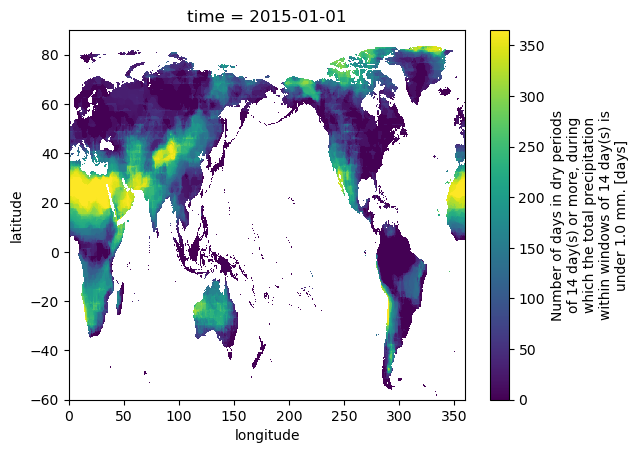

In [22]:
out_ds['dry_spell_days'].plot()

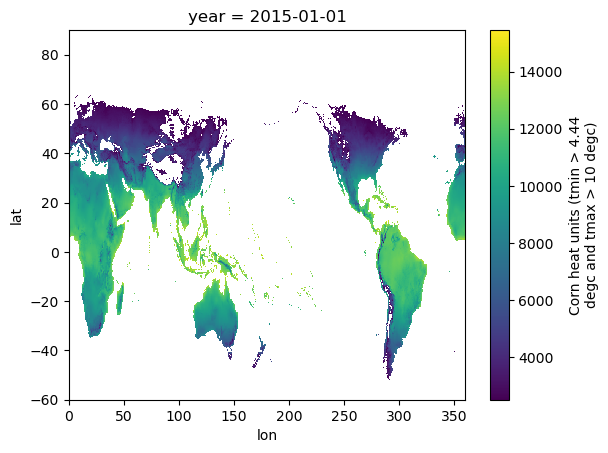

In [28]:
out_ds['CornPossible']

In [23]:
gcm = 'CanESM5'
scenario='historical'
year=2009
dryspell_treshold=1.0
dryspell_length=14
ds = load_nasanex(gcm=gcm, scenario=scenario,
                              variables=['tasmax', 'pr', 'tasmin'], 
                              years=[year], nasanex_df=nasa_nex_runs)
corn_units = xclim.indicators.atmos.corn_heat_units(ds=ds)#.groupby('time.year')#.sum()

# find out WHEN the corn units are over a certain threshold
warm_enough = (corn_units.groupby('time.year').sum() > NECESSARY_HEAT_UNITS)

results = xclim.indicators.atmos.dry_spell_total_length(ds=ds, 
                                                           window=dryspell_length
                                                          ).rename({'time': 'year'})
results = results.assign_coords({'year': [pd.to_datetime(year, format='%Y')]})
results = results.to_dataset(name='dry_spell_days').astype('float')

no_dry_spells_mask = results['dry_spell_days']<14

results['CornPossible'] = corn_units.groupby('time.year').sum().where(warm_enough).assign_coords({'year': [pd.to_datetime(year, format='%Y')]})
# This does not account for thermal stresses due to high temperatures
# as outlined in https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7913793/
results['CornSafe'] = results['CornPossible'].where(no_dry_spells_mask).assign_coords({'year': [pd.to_datetime(year, format='%Y')]})

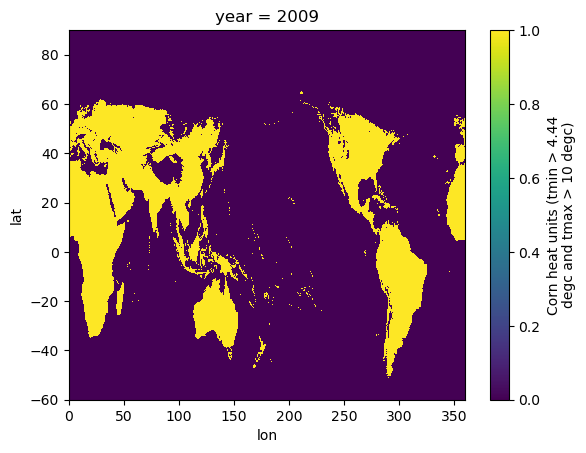

In [16]:
warm_enough.plot()

In [22]:
corn_units.groupby('time.year').sum().where(warm_enough)

<xarray.DataArray 'chu' (year: 1, lat: 600, lon: 1440)>
dask.array<where, shape=(1, 600, 1440), dtype=float32, chunksize=(1, 600, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -59.88 -59.62 -59.38 -59.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * year     (year) int64 2009
Attributes:
    units:          
    standard_name:  air_temperature
    cell_measures:  area: areacella
    original_name:  STMX
    cell_methods:   tasmin: area: mean time: minimum tasmax: area: mean time:...
    history:        tasmin: \ntasmax: \n[2023-04-13 21:11:03] chu: CORN_HEAT_...
    long_name:      Corn heat units (tmin > 4.44 degc and tmax > 10 degc)
    description:    Temperature-based index used to estimate the development ...

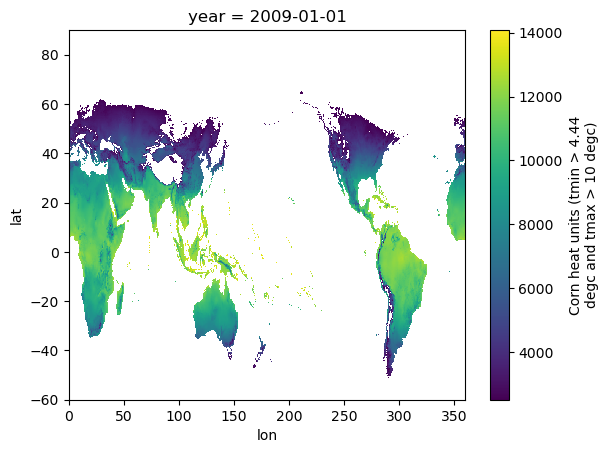

In [24]:
results['CornPossible'].plot()